In [1]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [14]:
import pyart

# Example list of radar files
filenames = [
    "C:/Users/omitu/Desktop/Research/CFAD/Data/KHGX20210628_134937_V06", 
    "C:/Users/omitu/Desktop/Research/CFAD/Data/KHGX20210628_001054_V06" # Example file path
    # Add more file paths here
]

# List to store grids
grids = []
radars = []

# Loop over each file
for filename in filenames:
    # Read the radar file
    radar = pyart.io.read(filename)

    # Set weighting function
    weight_func = 'Barnes'  # Options: 'nearest', 'Cressman', 'Barnes'

    # Create a gate filter
    gfilter = pyart.filters.GateFilter(radar)
    gfilter.exclude_below('cross_correlation_ratio', 0.8)
    gfilter.exclude_below('reflectivity', -20)

    # Create a grid based on our radar object
    grid = pyart.map.grid_from_radars(
        radar,
        grid_shape=(41, 401, 401),
        gridding_algo='map_gates_to_grid',
        weighting_function=weight_func,
        gatefilters=gfilter,
        grid_limits=(
            (0.0, 20000),
            (-100000.0, 100000.0),
            (-100000, 100000.0),
        ),
    )

    # Store the grid for further processing
    grids.append(grid)
    radars.append(radar)

    # Additional processing can be done here
    # For example, working with the grid data


In [15]:
#CFAD settings
zlims=[-20, 65]
zdrlims=[-1, 3]
rholims=[0.9, 1.02]
kdplims=[-1,3]
#lims = [-50000,0,-75000,30000]
lims=[-100000,-50000,-50000,50000]
#lims = [-50000,50000,-50000,50000]
ymax=10
norm_opt = 2 #1) Normalize at each height only, 2) Normalize across all heights

#CFAD increment
dz = 5
dzdr = 0.5
drho = 0.0025
dkdp = 0.1

#KDP calc
kdp_calc = False

In [18]:
#grid.z["data"]
Z=grids[0].fields['reflectivity']['data']
rho=grids[0].fields['cross_correlation_ratio']['data']
ZDR=grids[0].fields['differential_reflectivity']['data']
#kdp=grid.fields['kdp']['data']
#Z.shape

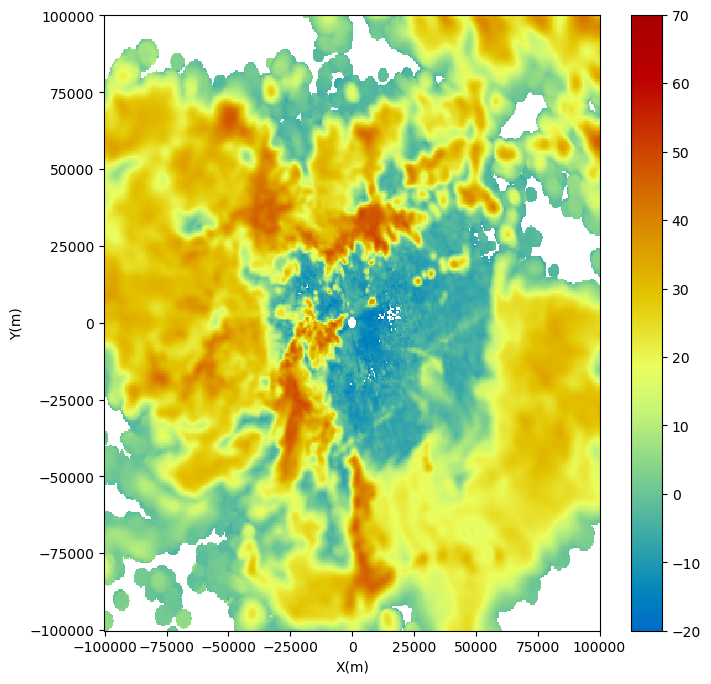

In [19]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:

[X,Y]=np.meshgrid(grids[0].x["data"],grids[0].y["data"])
lev=2 #Level of analysis
fig = plt.figure(figsize=(8,8))
plt.pcolormesh(X,Y,np.squeeze(Z[lev,:,:]),cmap='pyart_HomeyerRainbow',vmin=-20,vmax=70)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar()
plt.savefig('Strat_Z_'+weight_func+'.png')



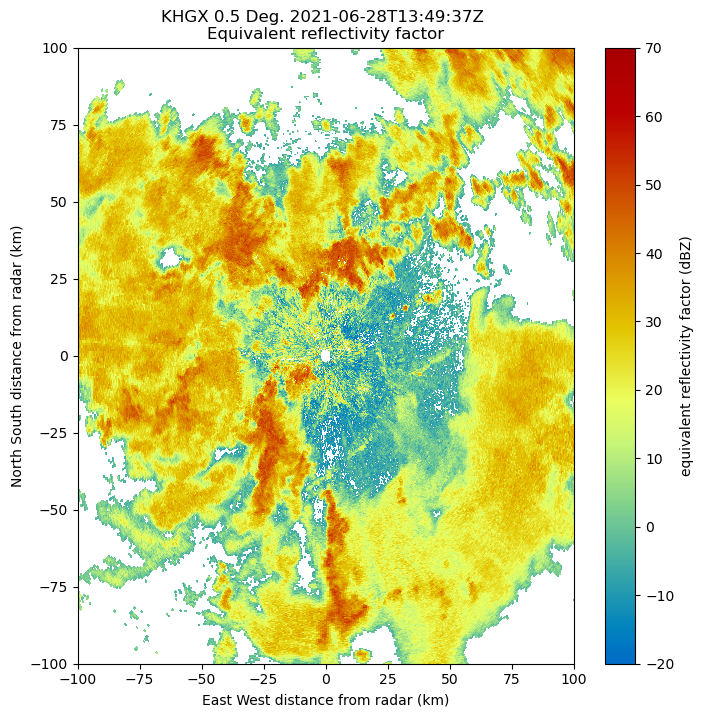

In [20]:
fig = plt.figure(figsize=(8,8))
display = pyart.graph.RadarDisplay(radars[0])
display.plot_ppi('reflectivity',sweep=0,vmin=-20,vmax=70)
display.set_limits(xlim=(-100,100),ylim=(-100,100))
#plt.savefig('Raw_Z.png')

In [21]:
def cfad_calc(data_list, bins, lims, norm_opt=1):
    # Initialize combined histogram
    combined_hist2d = None
    
    # Calculate histogram for each dataset and combine them
    for data in data_list:
        # Initialize histogram for the current dataset
        hist2d = np.zeros((np.size(bins)-1, data.shape[0]))

        # Check if the user wants a limited domain
        limit_domain = np.size(lims) > 1
        if(limit_domain):
            [a, b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3]))

        # Loop over all heights
        for lev in range(data.shape[0]):
            if limit_domain:
                data_hist = np.ma.compressed(data[lev, a, b])
            else:
                data_hist = np.ma.compressed(data[lev, :, :])

            # Calculate histogram for current dataset
            histogram, bin_edges = np.histogram(np.ravel(data_hist), bins)
            hist2d[:, lev] = histogram

        # Combine histograms from all datasets
        if combined_hist2d is None:
            combined_hist2d = hist2d
        else:
            combined_hist2d += hist2d

    # Normalize the combined histogram
    if norm_opt == 1:
        combined_hist2d = np.divide(combined_hist2d, np.sum(combined_hist2d, axis=0), where=np.sum(combined_hist2d, axis=0) != 0)
    elif norm_opt == 2:
        combined_hist2d /= np.max(combined_hist2d)

    bin_ctrs = (bins[:-1] + bins[1:]) / 2

    return combined_hist2d, bin_ctrs


def vert_stats(data_list, lims):
    combined_stats = None

    # Calculate statistics for each dataset and combine them
    for data in data_list:
        if np.size(lims) > 1:
            [a, b] = np.where((X > lims[0])*(X < lims[1])*(Y > lims[2])*(Y < lims[3])) 
            data_stats = np.ma.median(data[:, a, b], axis=1)
        else:
            data_stats = np.ma.mean(np.ma.mean(data, axis=2), axis=1)

        # Combine statistics from all datasets
        if combined_stats is None:
            combined_stats = data_stats
        else:
            combined_stats += data_stats

    # Average the combined statistics
    combined_stats /= len(data_list)

    return combined_stats



In [24]:
#CFAD X
data = [grids[0].fields['reflectivity']['data'], grids[1].fields['reflectivity']['data']]
binsZ = np.arange(zlims[0], zlims[1], dz)

[hist_Z, Zctr] = cfad_calc(data,binsZ,lims,norm_opt)
#hist_Z /= dz
meanZ = vert_stats(data,lims)

#CFAD ZDR
data = [grids[0].fields['differential_reflectivity']['data'], grids[1].fields['differential_reflectivity']['data']]
binsZDR = np.arange(zdrlims[0], zdrlims[1], dzdr)
[hist_ZDR, ZDRctr] = cfad_calc(data,binsZDR,lims,norm_opt)
#hist_ZDR /= (dzdr*10)
meanZDR = vert_stats(data,lims)

#CFAD rhohv
data = [grids[0].fields['cross_correlation_ratio']['data'], grids[1].fields['cross_correlation_ratio']['data']]
binsrho = np.arange(rholims[0], rholims[1], drho)
[hist_rho, rhoctr] = cfad_calc(data,binsrho,lims,norm_opt)
#hist_rho /= (drho*10000)
meanrho = vert_stats(data,lims)

#CFAD KDP
if(kdp_calc):
    data = kdp
    binskdp = np.arange(kdplims[0], kdplims[1], dkdp)
    [hist_kdp,kdpctr] = cfad_calc(data,binskdp,lims,norm_opt)
    #hist_kdp /= (dkdp*100)
    meankdp = vert_stats(data,lims)

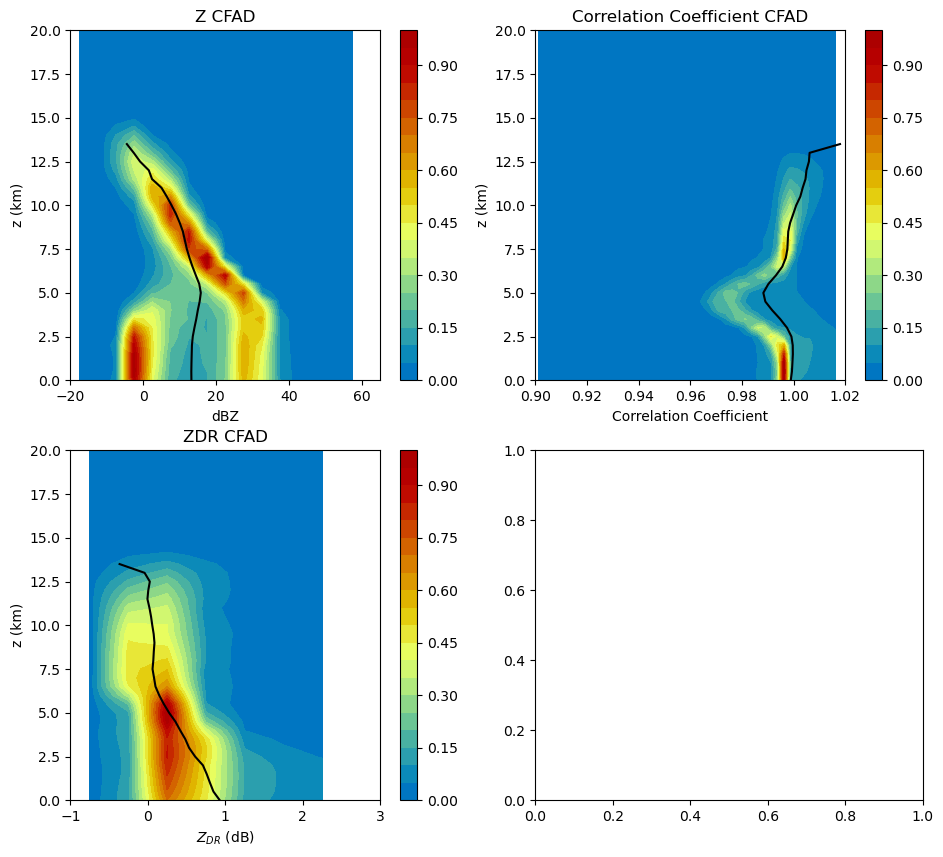

In [25]:
#Plotting levels for contours
ymax=20
fig,ax = plt.subplots(2,2,figsize=(11,10))
[z,b]=np.meshgrid(grid.z["data"],Zctr)
pcm=ax[0,0].contourf(b,z/1000,hist_Z,levels=20,cmap='pyart_HomeyerRainbow')
ax[0,0].plot(meanZ,grid.z["data"]/1000,'-k')
#ax[0,0].contour(b,z/1000,hist_Z,levels=np.arange(0.05,1,0.05),colors='k')
ax[0,0].set_xlabel('dBZ')
ax[0,0].set_ylabel('z (km)')
ax[0,0].set_title('Z CFAD')
#ax[0,0].set_title('Z CFAD (% of Data per dBZ per km)')
ax[0,0].set_xlim(zlims)
ax[0,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,0])

[z,b]=np.meshgrid(grid.z["data"],ZDRctr)
pcm=ax[1,0].contourf(b,z/1000,hist_ZDR,levels=20,cmap='pyart_HomeyerRainbow')
#ax[1,0].contour(b,z/1000,hist_ZDR,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[1,0].plot(meanZDR,grid.z["data"]/1000,'-k')
ax[1,0].set_xlabel('$Z_{DR}$ (dB)')
ax[1,0].set_ylabel('z (km)')
#ax[1,0].set_title('ZDR CFAD (% of Data per 0.1 dB per km)')
ax[1,0].set_title('ZDR CFAD')
ax[1,0].set_xlim(zdrlims)
ax[1,0].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[1,0])

[z,b]=np.meshgrid(grid.z["data"],rhoctr)
pcm=ax[0,1].contourf(b,z/1000,hist_rho,levels=20,cmap='pyart_HomeyerRainbow')
#ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
ax[0,1].plot(meanrho,grid.z["data"]/1000,'-k')
ax[0,1].set_xlabel('Correlation Coefficient')
ax[0,1].set_ylabel('z (km)')
#ax[0,1].set_title('Correlation Coefficient CFAD (% of Data per 0.001 CC per km)')
ax[0,1].set_title('Correlation Coefficient CFAD')
ax[0,1].set_xlim(rholims)
ax[0,1].set_ylim(0,ymax)
fig.colorbar(pcm, ax=ax[0,1])

if(kdp_calc):
    [z,b]=np.meshgrid(grid.z["data"],kdpctr)
    pcm=ax[1,1].contourf(b,z/1000,hist_kdp,levels=20,cmap='pyart_HomeyerRainbow')
    #ax[0,1].contour(b,z/1000,hist_rho,levels=np.arange(0.05,0.5,0.05),colors='k')
    ax[1,1].plot(meankdp,grid.z["data"]/1000,'-k')
    ax[1,1].set_xlabel('Specific Differential Phase (deg/km)')
    #ax[1,1].set_title('KDP CFAD (% of Data per 0.01 deg/km per km)')
    ax[1,1].set_title('KDP CFAD')
    ax[1,1].set_ylabel('z (km)')
    ax[1,1].set_ylim(0,ymax)
    ax[1,1].set_xlim(kdplims)
    fig.colorbar(pcm, ax=ax[1,1])

fig.savefig('CFAD_norm.png')

